pip install dash
pip install dash-bootstrap-components
pip install dash-mantine-components==0.12.1
pip install dash-holoniq-wordcloud

**SATISFACTION CLIENT SENTIMENT ANALYSIS AND DASHBOARD**

In [26]:
# Import packages
import dash
from dash import Dash, html, dash_table, dcc, callback, Output, Input
from dash_holoniq_wordcloud import DashWordcloud
import pandas as pd
import plotly.express as px
import dash_bootstrap_components as dbc
import re
import numpy as np
import datetime
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import warnings
warnings.filterwarnings("ignore")
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


**Load data**

In [27]:
#Load company infos
df = pd.read_csv(r"D:\PROFIL\BCRK1417\Documents\Parcours_FEST\work\codes\de_satisfaction_client\data\informations_entreprises.csv", sep=',',decimal='.')

# Load comments per company
df_comments = pd.read_json(r"D:\PROFIL\BCRK1417\Documents\Parcours_FEST\work\codes\de_satisfaction_client\data\df_commentaires_par_entreprise.json")

df

,town,country,institution_type,company_name,trust_score,review,five_star_%
0,Portland,United States,Financial Institution,Evergreen Credit Union,4.9,340,96%
1,Lincoln,United States,ATM,Liberty First Credit Union,4.7,304,92%
2,Irvine,United States,Bank,GoHenry by Acorns,4.3,3300,66%
3,Chicago,United States,Alternative Financial Service,Crypto Dispensers,4.1,214,64%
4,Atlanta,United States,Bank,Anytime Capital,4.5,19,95%
5,San Francisco,United States,Financial Institution,Swadesh,4.4,10,100%
6,Cleveland,United States,Vending Machine Supplier,VapeTM,4.1,5,100%
7,San Diego,United States,Business to Business Service,The Payment HQ,4.0,4,100%
8,San Jose,United States,Debt Relief Service,Meriwest Credit Union,3.8,9,67%
9,Las Vegas,United States,ATM,Coinhub Bitcoin ATM,3.7,8,37%


**Data cleanning/Preprocessing**

In [28]:
from sklearn.impute import SimpleImputer
import numpy as np

def company_preprocessing(df):
    #rename col
    df.rename(columns={"review": "nombre_reviews"}, inplace=True)

    #remove white spaces
    df.town =df.town.apply(lambda x: str(str(x).strip().upper()).replace('nan', 'NaN').replace('NAN','NaN'))
    df.country =df.country.apply(lambda x: str(str(x).strip()).replace('nan', 'NaN'))
    df.institution_type =df.institution_type.apply(lambda x: str(str(x).strip()).replace('nan', 'NaN'))

    #replace Nan with most frequent
    imputer = SimpleImputer(missing_values='NaN', strategy='most_frequent')
    df.loc[:,['town','country','institution_type']] = imputer.fit_transform(df[['town','country','institution_type']])

    #replace trust_score,nombre_reviews,five_star_%; nan by zero
    df['trust_score'] = df['trust_score'].fillna(0)
    df['five_star_%'] = df['five_star_%'].fillna(0)
    df['five_star_%']= df['five_star_%'].apply(lambda x: str(x).replace('0','0%') if len(str(x))==1 else x)
    df['nombre_reviews'] = df['nombre_reviews'].fillna(0)

    #Short company_name
    df['short_company_name'] = df['company_name']
    df['company_name']= df['short_company_name'].apply(lambda x: str(x).strip()[:7] + "...")
    
    return df



In [29]:
df = company_preprocessing(df)
df

,town,country,institution_type,company_name,trust_score,nombre_reviews,five_star_%,short_company_name
0,PORTLAND,United States,FiNaNcial Institution,Evergre...,4.9,340,96%,Evergreen Credit Union
1,LINCOLN,United States,ATM,Liberty...,4.7,304,92%,Liberty First Credit Union
2,IRVINE,United States,Bank,GoHenry...,4.3,3300,66%,GoHenry by Acorns
3,CHICAGO,United States,Alternative FiNaNcial Service,Crypto ...,4.1,214,64%,Crypto Dispensers
4,ATLANTA,United States,Bank,Anytime...,4.5,19,95%,Anytime Capital
5,SAN FRANCISCO,United States,FiNaNcial Institution,Swadesh...,4.4,10,100%,Swadesh
6,CLEVELAND,United States,Vending Machine Supplier,VapeTM...,4.1,5,100%,VapeTM
7,SAN DIEGO,United States,Business to Business Service,The Pay...,4.0,4,100%,The Payment HQ
8,SAN JOSE,United States,Debt Relief Service,Meriwes...,3.8,9,67%,Meriwest Credit Union
9,LAS VEGAS,United States,ATM,Coinhub...,3.7,8,37%,Coinhub Bitcoin ATM


**Sentiment Analysis**

In [30]:
def company_comment_processing(df_comments):

    df_comments['company_name']= df_comments['company_name'].apply(lambda x: str(x).strip()[:11] + "...")

    text_df = df_comments.drop(['User', 'localisation', 'Titre','nombre_reviews', 'date_experience', 'reply'
           ], axis=1)
           
    text_df.rename(columns={'commentaire': 'text'}, inplace=True)
    #text_df.head()

    return text_df

#Comment processing
def comments_preprocessing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]

    return " ".join(filtered_text)

#Stream word
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

#Polarity fxn
def polarity(text):
    return TextBlob(text).sentiment.polarity

#Comment status
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"


def comment_polarity(text_df):
    
    #text_df.text = text_df['text'].apply(comments_preprocessing)
    text_df = text_df.drop_duplicates('text')

    #apply streamer
    text_df['text'] = text_df['text'].apply(lambda x: stemming(x))

    #compute polarity
    text_df['polarity'] = text_df['text'].apply(polarity)

    #Detect comment polarity
    text_df['sentiment'] = text_df['polarity'].apply(sentiment)

    return text_df


def compute_sentiment_analysis(df_comments):

    text_df = company_comment_processing(df_comments)

    df_polarity =pd.DataFrame()

    for company in text_df.company_name.unique():
        text_df[text_df.company_name==company]
        comp_pol =comment_polarity(text_df[text_df.company_name==company])
        comp_pol['company_name']= company
        df_polarity= pd.concat([df_polarity,comp_pol])

    #fig = plt.figure(figsize=(5,5))
    #sns.countplot(x='sentiment', data = df_polarity)
    return df_polarity


**Dashboards**

In [32]:

warnings.filterwarnings("ignore")
# Load data
#df = pd.read_csv('atm_company_info.csv')

# Initialize Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])


################################################################################################################
###### Company Analysis 
################################################################################################################
# Map Visualization
#map_fig = px.scatter_mapbox(df, lat='latitude', lon='longitude', hover_name='company_name',
#                            color='trust_score', size='trust_score',
#                            mapbox_style="carto-positron", zoom=3, height=500)

# Company Trust Score Bar Chart
trust_fig = px.bar(df, y='company_name', x='trust_score', color='trust_score', title="Trust Score by Company")
trust_fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'}, height=500)

# Institution Type Pie Chart
institution_fig = px.pie(df, names='institution_type', title="Institution Type Distribution")

# Review Distribution Histogram
# Remove the '%' sign and convert to numeric type
df['five_star_%'] = df['five_star_%'].str.rstrip('%').astype('float')
df = df.sort_values('five_star_%')
df['five_star_%'] = df['five_star_%'].astype(str) + '%'
review_dist_fig = px.histogram(df, x='five_star_%', title="Review Distribution", color='five_star_%')

# Top Reviewed Companies
top_companies_fig = px.bar(df.sort_values(by='nombre_reviews', ascending=False).head(10), 
                           x='company_name', y='nombre_reviews', title="Top Reviewed Companies")

# Company Comparison Radar Chart (trust_score vs five_star_%)
df_melt = pd.melt(df, id_vars=['company_name'], value_vars=['trust_score', 'five_star_%'])
comparison_fig = px.line_polar(df_melt, r='value', theta='variable', color='company_name', 
                               line_close=True, title="Company Comparison")

############### Add filters
# Dropdown Filters
dropdown_town = dcc.Dropdown(
    id='filter-town',
    options=[{'label': x, 'value': x} for x in df['town'].unique()],
    multi=True,
    placeholder="Select a town"
)
# Dropdown Filters
dropdown_country = dcc.Dropdown(
    id='filter-country',
    options=[{'label': x, 'value': x} for x in df['country'].unique()],
    multi=False,
    placeholder="Select a Country"
)

# Filtered Trust Score Chart
#@app.callback(
#    dash.dependencies.Output('filtered-graph', 'figure'),
#    [dash.dependencies.Input('filter-dropdown', 'value')]
#)

def update_graph(selected_countries):
    if selected_countries:
        filtered_df = df[df['town'].isin(selected_countries)]
    else:
        filtered_df = df
    
    fig = px.bar(filtered_df, x='company_name', y='trust_score', color='trust_score', title="Filtered Trust Score")
    return fig

################################################################################################################
###### Comment Sentiment Analysis 
################################################################################################################
#print(" Comment Sentiment Analysis")


# Example sentiment analysis - dummy data
#df_comments['sentiment'] = df_comments['commentaire'].apply(lambda x: 'Positive' if 'good' in x else 'Negative')

df_polarity = compute_sentiment_analysis(df_comments)
# Sentiment Analysis Bar Chart
sentiment_fig = px.bar(df_polarity, x='company_name', color='sentiment', title="Sentiment Analysis")

# Comments Over Time Line Chart
df_comments['date_experience'] = pd.to_datetime(df_comments['date_experience'])
df_comments['year'] = df_comments.date_experience.dt.year
df_g = df_comments.groupby(['year', 'company_name']).size().reset_index()
df_g.rename(columns={0: 'nbr_comments'}, inplace=True)
comments_over_time_fig = px.line(df_g, x='year', y='nbr_comments', title="Comments Over Time", color='company_name', markers=True)


################################################################################################################
###### Dashboards/layouts 
################################################################################################################
app.layout = dbc.Container([
    dbc.Row([        
        #dbc.Col([dcc.Graph(figure=map_fig)], width=12),
        dbc.Col([html.H4("Company Dashboard")], width=12),
        dbc.Col([dropdown_town], width=6),dbc.Col([dropdown_country], width=6),
        dbc.Col([dcc.Graph(figure=trust_fig)], width=6),
        dbc.Col([dcc.Graph(figure=institution_fig)], width=6),
        dbc.Col([dcc.Graph(figure=top_companies_fig)], width=6),
        dbc.Col([dcc.Graph(figure=review_dist_fig)], width=6),
        dbc.Col([dcc.Graph(figure=comparison_fig)], width=6),
        #dbc.Col([dcc.Graph(id='filtered-graph')], width=6),
    ]),
    dbc.Row([        
        dbc.Col([html.H4("User Feedback Dashboard")], width=12),
        dbc.Col([dcc.Graph(figure=sentiment_fig)], width=6),
        dbc.Col([dcc.Graph(figure=comments_over_time_fig)], width=6), 
 
    ]),
])

if __name__ == "__main__":
    app.run_server(debug=True)


<AxesSubplot: xlabel='sentiment', ylabel='count'>

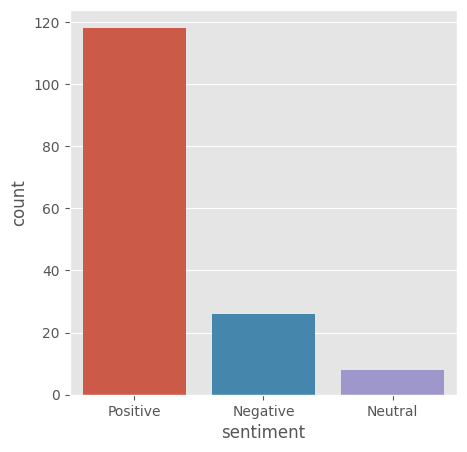

In [10]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = df_polarity)

Text(0.5, 1.0, 'Distribution of sentiments')

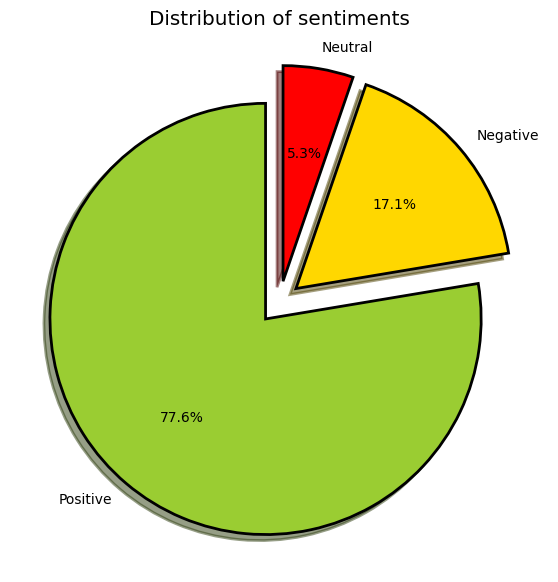

In [11]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df_polarity['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

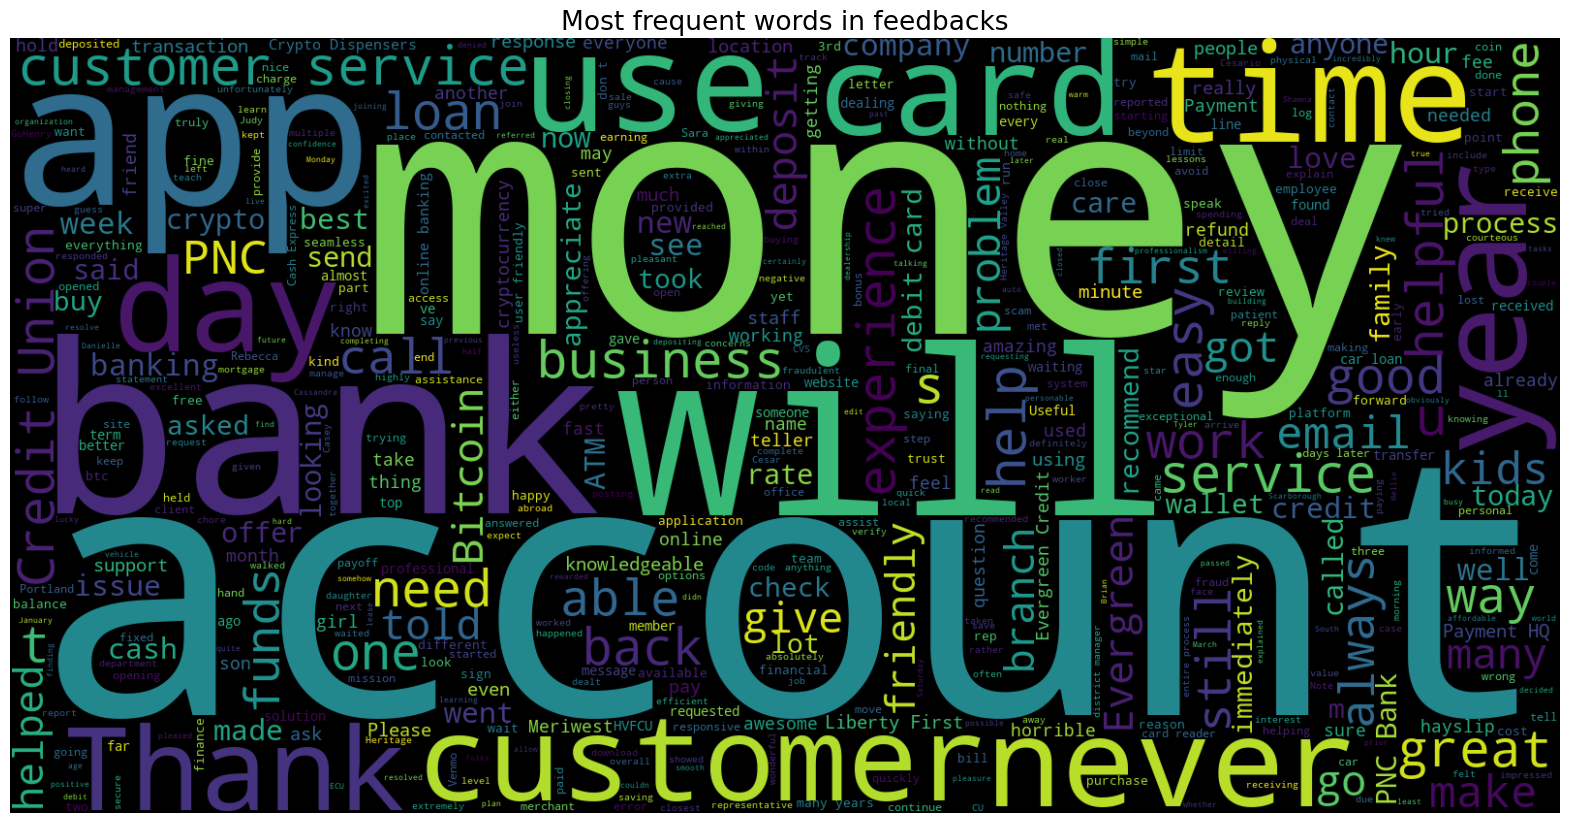

In [15]:
text = ' '.join([word for word in df_polarity['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in feedbacks', fontsize=19)
plt.show()

In [21]:
security_data = [
    ["Equity", 74, "Zillions of equity based funds"],
    ["Bond", 45],
    ["Global", 30],
    ["Sector Equity", 17],
    ["EUR", 15],
    ["Large Cap", 13],
    ["Europe", 11],
]

app.layout = html.Div([
    html.Div([
        DashWordcloud(
            id='wordcloud',
            list=security_data,
            width=300, height=200,
            gridSize=16,
            color='#f0f0c0',
            backgroundColor='#001f00',
            shuffle=False,
            rotateRatio=0.5,
            shrinkToFit=True,
            shape='circle',
            hover=True
            )
        ])
    ])
